Restarted GenAMM (Python 3.11.4)

In [16]:
import pickle
import qGaussian
import qlogNormal
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
sns.set_theme()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

dataset_path = '../data/usdc_weth_005.pickle'
with open(dataset_path, 'rb') as f:
    df = pickle.load(f)
df.index = pd.to_datetime(df.index)

df = df[ (df.index >= datetime(2023, 1, 1, 0, 0, 0)) & (df.index < datetime(2024, 1, 1, 0, 0, 0)) ]
df_swap = df[ (df.Event=='Swap_X2Y') | (df.Event=='Swap_Y2X') ]
df_mint = df[ df.Event=='Mint' ]
df_burn_mint = df[ (df.Event=='Burn') | (df.Event=='Mint') ]
df_burn = df[ df.Event=='Burn' ]

'''
df_burn_mint_full = df_burn_mint.copy()
df_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]
df_swap_full = df_swap.copy()
df_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]
'''

"\ndf_burn_mint_full = df_burn_mint.copy()\ndf_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]\ndf_swap_full = df_swap.copy()\ndf_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]\n"

In [17]:
# Import no L.O. data
with open('../data/df_burn_clean.pickle', 'rb') as f:
    df_burn_clean = pickle.load(f)

df_burn_clean[[
    'tick_lower', 'tick_upper', 'block_number', 'tick'
    ]] =df_burn_clean[[
        'tick_lower', 'tick_upper', 'block_number', 'tick']].astype(int)
df_burn_clean[[
    'amount', 'amount0', 'amount1'
    ]] =df_burn_clean[[
        'amount', 'amount0', 'amount1']].astype(np.float32)

log_liquidity = np.log(df_burn_clean.amount.values)

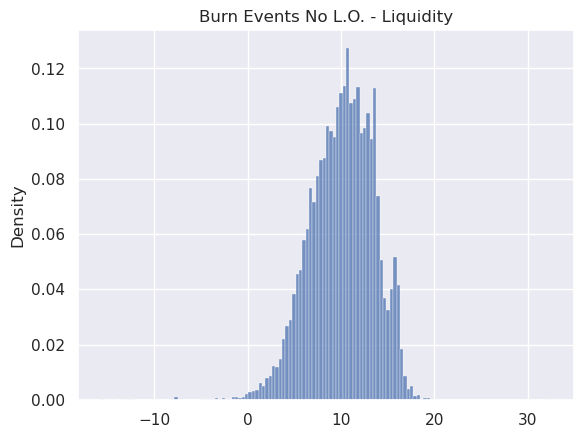

In [18]:
# Plot the data
sns.histplot(log_liquidity, stat='density', label='Data')
plt.title("Burn Events No L.O. - Liquidity")
plt.show()

In [21]:
# Comparison between distributions
from scipy import stats as sc_stats
y_temp = log_liquidity.copy()

def general_ll(x, pdf_func, pars):
    return np.sum(np.log(pdf_func(x, *pars)))
    
max_ll, best_dist = -np.inf, None
for dist, name in zip(
    [sc_stats.cauchy, sc_stats.chi2, sc_stats.crystalball, sc_stats.erlang,
     sc_stats.exponnorm, sc_stats.fisk, sc_stats.genlogistic, sc_stats.gennorm,
     sc_stats.gengamma, sc_stats.genhyperbolic, sc_stats.geninvgauss,
     sc_stats.gumbel_l, sc_stats.johnsonsb, sc_stats.johnsonsu, sc_stats.logistic,
     sc_stats.loggamma, sc_stats.lognorm, sc_stats.nakagami, sc_stats.norminvgauss,
     sc_stats.powernorm, sc_stats.recipinvgauss, sc_stats.skewnorm, sc_stats.t,
     sc_stats.weibull_min, qGaussian, qlogNormal],
    ['cauchy', 'chi2', 'crystalball', 'erlang', 'exponnorm', 'fisk', 'genlogistic',
     'gennorm', 'gengamma', 'genhyperbolic', 'geninvgauss', 'gumbel_l', 'johnsonsb',
     'johnsonsu', 'logistic', 'loggamma', 'lognorm', 'nakagami', 'norminvgauss',
     'powernorm', 'recipinvgauss', 'skewnorm', 't', 'weibull_min',
     'qGaussian', 'qlogNormal']):
    try:
        if name not in ['qGaussian', 'qlogNormal']:
            pars = dist.fit(y_temp)
            print(f"{name} - Parameters: {pars}")
            curr_ll = general_ll(y_temp, dist.pdf, pars)
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        else:
            pars = dist.fit(y_temp)
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(y_temp, dist.pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
    except Exception as e:
        print(f"{name} - Error: {e}")
    print('')

cauchy - Parameters: (10.433922975677925, 2.1174508356420176)
cauchy - Log-Likelihood: -52075.249382182126

chi2 - Parameters: (0.4715833290980823, -15.789137706678897, 1.5239699784974698)
chi2 - Log-Likelihood: -231926.33362382976

crystalball - Parameters: (1006.3629077192275, 821.9456190653409, 10.148223831853368, 3.3968762163105666)
crystalball - Log-Likelihood: -48615.99119515948

erlang - Parameters: (215.4535294502761, -40.60379729093159, 0.23545359731221338)
erlang - Log-Likelihood: -48855.44686162455

exponnorm - Parameters: (0.013965414449856736, 10.105062866853613, 3.3972561852648724)
exponnorm - Log-Likelihood: -48616.0157317696

fisk - Parameters: (13057.037054157512, -25339.051787464326, 25349.305958562527)
fisk - Log-Likelihood: -48735.76115695881

genlogistic - Parameters: (0.6867180378560502, 11.311995333959487, 1.6666368931566866)
genlogistic - Log-Likelihood: -48663.69715554721

gennorm - Parameters: (1.9462169019673357, 10.15866683085121, 4.735783933703123)
gennorm 

In [22]:
print(f"The best distribution is: {best_dist}, with a Log-Likelihood of {max_ll}")

The best distribution is: johnsonsu, with a Log-Likelihood of -48351.965073975356


(4.3767236746950875, 5.005796528009103, 22.055029688801547, 11.789124969143977)


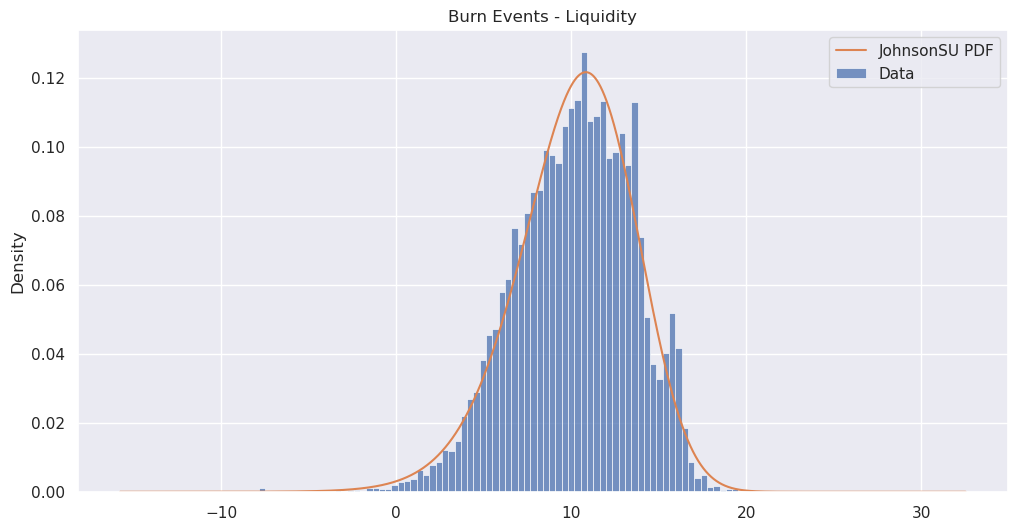

In [23]:
pars_jh = sc_stats.johnsonsu.fit(y_temp)
print(pars_jh)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, ax=ax, stat='density', label='Data')

pdf = sc_stats.johnsonsu.pdf(
    np.linspace(np.min(y_temp), np.max(y_temp), 10000), *pars_jh)
sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='JohnsonSU PDF')

plt.title("Burn Events - Liquidity")
ax.legend()
plt.show()

In [24]:
# Comparison test
class Fit_comparison_test():
    '''
    Fit comparison test for assessing the goodness of the Expected Shortfall estimate
    '''
    def __init__(self, one_side=True, n_boot=10_000):
        '''
        Args:
            one_side (bool): if True, the test is one sided (i.e. H0: mu >= mu_target). Default is False
            n_boot (int): the number of bootstrap replications. Default is 10_000
        '''
        self.mu_target = 0
        self.one_side = one_side
        self.n_boot = n_boot
    
    def null_statistic(self, B_data):
        '''
        Compute the null statistic for the bootstrap sample
        Args:
            B_data (numpy array): the bootstrap sample

        Returns:
            float: the null statistic
        '''
        return (np.mean(B_data) - self.obs_mean) * np.sqrt(self.n) / np.std(B_data)
    
    def statistic(self, data):
        '''
        Compute the test statistic for the original sample
        Args:
            data (numpy array): the original sample

        Returns:
            float: the test statistic
        '''
        return (self.obs_mean - self.mu_target) * np.sqrt(self.n) / np.std(data)
    
    def fit_transform(self, data, pdf1, pdf2):
        '''
        Transform the data to compute the Fit comparison test
        Args:
            Q_ (numpy array): the quantile estimates
            E_ (numpy array): the expected shortfall estimates
            Y_ (numpy array): the actual time series

        Returns:
            numpy array: the transformed data
        '''

        return np.log((pdf2(data))) - np.log(pdf1(data))

    def __call__(self, x, pdf_func_top, pdf_func_bench, seed=None):
        '''
        Compute the test

        Args:
            Q (numpy array): the quantile estimates
            E (numpy array): the expected shortfall estimates
            Y (numpy array): the actual time series
            seed (int): the seed for the random number generator. Default is None

        Returns:
            dict: a dictionary with the following keys_ 'statistic' (float; the test statistic), 'p_value' (float; the p-value of the test)
        '''
        data = self.fit_transform(x, pdf_func_top, pdf_func_bench)
        np.random.seed(seed)

        self.obs_mean = np.mean(data)
        self.n = len(data)

        B_stats = list()
        for _ in range(self.n_boot):
            B_stats.append( self.null_statistic(
                np.random.choice(data, size=self.n, replace=True) ))
        B_stats = np.array(B_stats)
        self.B_stats = B_stats
        
        if self.one_side:
            obs = self.statistic(data)
            return {'statistic':obs, 'p_value':np.mean(B_stats < obs)}
        else:
            obs = np.abs(self.statistic(data))
            return {'statistic':self.statistic(data),
                    'p_value':np.mean((B_stats > obs) | (B_stats < -obs))}

boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

top_dist = sc_stats.johnsonsu
top_pars = top_dist.fit(y_temp)
for dist, name in zip(
    [sc_stats.cauchy, sc_stats.chi2, sc_stats.crystalball, sc_stats.erlang,
     sc_stats.exponnorm, sc_stats.fisk, sc_stats.genlogistic, sc_stats.gennorm,
     sc_stats.gengamma, sc_stats.genhyperbolic, sc_stats.geninvgauss,
     sc_stats.gumbel_l, sc_stats.johnsonsb, sc_stats.logistic,
     sc_stats.loggamma, sc_stats.lognorm, sc_stats.nakagami, sc_stats.norminvgauss,
     sc_stats.powernorm, sc_stats.recipinvgauss, sc_stats.skewnorm, sc_stats.t,
     sc_stats.weibull_min, qGaussian, qlogNormal],
    ['cauchy', 'chi2', 'crystalball', 'erlang', 'exponnorm', 'fisk', 'genlogistic',
     'gennorm', 'gengamma', 'genhyperbolic', 'geninvgauss', 'gumbel_l', 'johnsonsb',
     'logistic', 'loggamma', 'lognorm', 'nakagami', 'norminvgauss',
     'powernorm', 'recipinvgauss', 'skewnorm', 't', 'weibull_min',
     'qGaussian', 'qlogNormal']):
    try:
        if name not in ['qGaussian', 'qlogNormal']:
            temp_par = dist.fit(y_temp)
            test_res = boot_test(
                y_temp, lambda x: top_dist.pdf(x, *top_pars),
                lambda x: dist.pdf(x, *temp_par), random_seed)
        else:
            temp_par = dist.fit(y_temp)
            test_res = boot_test(
                y_temp, lambda x: top_dist.pdf(x, *top_pars),
                lambda x: dist.pdf(x, *list(temp_par.values())[:-1]), random_seed)
        print(f"{name} - test result: {test_res}")
    except Exception as e:
        print(f"{name} - Error: {e}")

cauchy - test result: {'statistic': -66.83661572654312, 'p_value': 0.0}
chi2 - test result: {'statistic': -839.6043786954415, 'p_value': 0.0}
crystalball - test result: {'statistic': -6.47370743899741, 'p_value': 0.0}
erlang - test result: {'statistic': -7.446921807990988, 'p_value': 0.0}
exponnorm - test result: {'statistic': -6.4760749663321056, 'p_value': 0.0}
fisk - test result: {'statistic': -12.73436533794119, 'p_value': 0.0}
genlogistic - test result: {'statistic': -10.99709002163983, 'p_value': 0.0}
gennorm - test result: {'statistic': -6.920234837259898, 'p_value': 0.0}
gengamma - test result: {'statistic': -410.1995963561959, 'p_value': 0.0}
genhyperbolic - test result: {'statistic': -5.958456503293218, 'p_value': 0.0}
geninvgauss - test result: {'statistic': -205.91294989339983, 'p_value': 0.0}
gumbel_l - test result: {'statistic': -2.247222074269644, 'p_value': 0.0}
johnsonsb - test result: {'statistic': -1.4922992749484874, 'p_value': 0.0129}
logistic - test result: {'stat

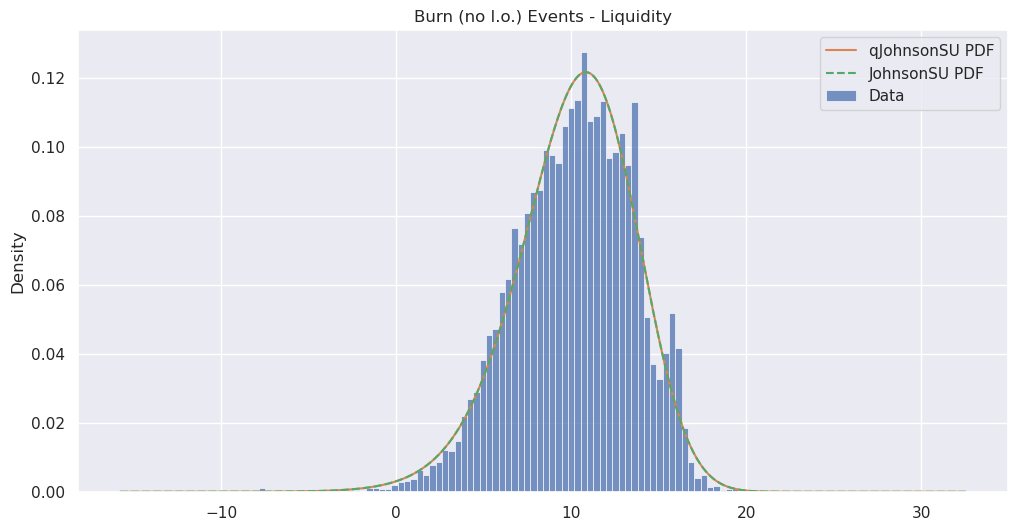

In [28]:
import qJohnsonSU
q_pars = qJohnsonSU.fit(y_temp)
pars_jh = sc_stats.johnsonsu.fit(y_temp)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, ax=ax, stat='density', label='Data')

pdf = qJohnsonSU.pdf(
    np.linspace(np.min(y_temp), np.max(y_temp), 10000),
    *list(q_pars.values())[:-1])
pdf = sc_stats.johnsonsu.pdf(
    np.linspace(np.min(y_temp), np.max(y_temp), 10000), *pars_jh)

sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='qJohnsonSU PDF')
sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf, linestyle='--',
            ax=ax, color=sns.color_palette()[2], label='JohnsonSU PDF')


plt.title("Burn (no l.o.) Events - Liquidity")
ax.legend()
plt.show()

In [ ]:
import qJohnsonSU
q_pars = qJohnsonSU.fit(y_temp)
print(q_pars)
print(f"qJohnsonSU - Log-Likelihood: {q_pars['neg_ll']}")
print(f"qJohnsonSU - Fitted params:")
for key in list(q_pars.keys())[:-1]:
    print(f"{key}: {q_pars[key]}")

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, ax=ax, stat='density', label='Data')

pdf = qJohnsonSU.pdf(
    np.linspace(np.min(y_temp), np.max(y_temp), 10000),
    *list(q_pars.values())[:-1])
sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='qJohnsonSU PDF')

plt.title("Burn Events - Liquidity")
ax.legend()
plt.show()

In [26]:
test_res = boot_test(
    y_temp, lambda x: qJohnsonSU.pdf(x, *list(q_pars.values())[:-1]),
    lambda x: top_dist.pdf(x, *top_pars), random_seed)
print('Assessing whenever the q version outperforms the JohnsonSU:')
print(test_res)

Assessing whenever the q version outperforms the JohnsonSU:
{'statistic': 0.49867819665658436, 'p_value': 0.7529}
